# Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
import krippendorff
from transformers import AutoTokenizer
import demoji
import re

DATA_BASE_PATH = "../data/training"

/home/elural/.conda/envs/exist-tfm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read data

In [17]:
df = pd.read_json(os.path.join(DATA_BASE_PATH, "EXIST2024_training.json"), orient="index")
unique_annotators = sorted({annotator for annotators in df['annotators'] for annotator in annotators})
# Create a mapping from annotator names to column indices
annotator_to_index = {annotator: index for index, annotator in enumerate(unique_annotators)}
df.head(2)

,id_EXIST,lang,text,meme,path_memes,number_annotators,annotators,gender_annotators,age_annotators,ethnicities_annotators,study_levels_annotators,countries_annotators,labels_task4,labels_task5,labels_task6,split
110001,110001,es,2+2=5 MITO Albert Einstein tenía bajo rendimie...,110001.jpeg,memes/110001.jpeg,6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 18-22, 23-45]","[Hispano or Latino, Hispano or Latino, Hispano...","[High school degree or equivalent, Master’s de...","[Mexico, Spain, Argentina, Spain, Mexico, Mexico]","[YES, YES, YES, YES, YES, YES]","[DIRECT, DIRECT, DIRECT, DIRECT, DIRECT, DIRECT]","[[IDEOLOGICAL-INEQUALITY, STEREOTYPING-DOMINAN...",TRAIN-MEME_ES
110002,110002,es,CUANDO UNA MUJER VA A LUCHAR POR SUS DERECHOS,110002.jpeg,memes/110002.jpeg,6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 18-22, 23-45]","[Hispano or Latino, Hispano or Latino, Hispano...","[High school degree or equivalent, Master’s de...","[Mexico, Spain, Argentina, Spain, Mexico, Mexico]","[YES, YES, YES, YES, YES, YES]","[DIRECT, DIRECT, DIRECT, DIRECT, DIRECT, JUDGE...","[[IDEOLOGICAL-INEQUALITY, STEREOTYPING-DOMINAN...",TRAIN-MEME_ES


In [3]:
df2 = pd.read_json(os.path.join(DATA_BASE_PATH, "EXIST2024Tweets_training.json"), orient="index")

In [13]:
gold_hard = pd.read_json(os.path.join(DATA_BASE_PATH, "evaluation/golds/EXIST2024_training_task4_gold_soft_2.json"), orient="records")
gold_tweets = pd.read_json(os.path.join(DATA_BASE_PATH, "evaluation/golds/EXIST2024_training_task1_gold_soft.json"), orient="records")

In [15]:
pd.concat([gold_hard, gold_tweets], ignore_index=True).to_json("EXIST2024_training_task4_gold_soft.json", orient="records")

# Read gold evaluation files

In [3]:
task1_hard_gold = pd.read_json(os.path.join(DATA_BASE_PATH, "evaluation/golds/EXIST2024_training_task1_gold_hard.json"))
task1_soft_gold = pd.read_json(os.path.join(DATA_BASE_PATH, "evaluation/golds/EXIST2024_training_task1_gold_soft.json"))
task2_hard_gold = pd.read_json(os.path.join(DATA_BASE_PATH, "evaluation/golds/EXIST2024_training_task2_gold_hard.json"))
task2_soft_gold = pd.read_json(os.path.join(DATA_BASE_PATH, "evaluation/golds/EXIST2024_training_task2_gold_soft.json"))
task3_hard_gold = pd.read_json(os.path.join(DATA_BASE_PATH, "evaluation/golds/EXIST2024_training_task3_gold_hard.json"))
task3_soft_gold = pd.read_json(os.path.join(DATA_BASE_PATH, "evaluation/golds/EXIST2024_training_task3_gold_soft.json"))

In [4]:
task4_hard_gold = pd.read_json(os.path.join(DATA_BASE_PATH, "evaluation/golds/EXIST2024_training_task4_gold_hard.json"))
task4_soft_gold = pd.read_json(os.path.join(DATA_BASE_PATH, "evaluation/golds/EXIST2024_training_task4_gold_soft.json"))
task5_hard_gold = pd.read_json(os.path.join(DATA_BASE_PATH, "evaluation/golds/EXIST2024_training_task5_gold_hard.json"))
task5_soft_gold = pd.read_json(os.path.join(DATA_BASE_PATH, "evaluation/golds/EXIST2024_training_task5_gold_soft.json"))
task6_hard_gold = pd.read_json(os.path.join(DATA_BASE_PATH, "evaluation/golds/EXIST2024_training_task6_gold_hard.json"))
task6_soft_gold = pd.read_json(os.path.join(DATA_BASE_PATH, "evaluation/golds/EXIST2024_training_task6_gold_soft.json"))

In [5]:
def add_id_column__to_gold_labels(df):
    df['id_EXIST'] = df["id"].values
    return df

def merge_task_with_gold(task_df, gold_df, column_name):
    return pd.merge(task_df, gold_df[["id_EXIST", column_name]], on="id_EXIST", how='outer')

def rename_value_columne(df, column_name):
    df = df.rename(columns={"value": column_name})
    return df

task1_hard_gold_1 = add_id_column__to_gold_labels(task1_hard_gold)
task1_hard_gold_1 = rename_value_columne(task1_hard_gold_1, "task4_hard")
task1_soft_gold_1 = add_id_column__to_gold_labels(task1_soft_gold)
task1_soft_gold_1 = rename_value_columne(task1_soft_gold_1, "task4_soft")

task2_hard_gold_1 = add_id_column__to_gold_labels(task2_hard_gold)
task2_hard_gold_1 = rename_value_columne(task2_hard_gold_1, "task5_hard")
task2_soft_gold_1 = add_id_column__to_gold_labels(task2_soft_gold)
task2_soft_gold_1 = rename_value_columne(task2_soft_gold_1, "task5_soft")

task3_hard_gold_1 = add_id_column__to_gold_labels(task3_hard_gold)
task3_hard_gold_1 = rename_value_columne(task3_hard_gold_1, "task6_hard")
task3_soft_gold_1 = add_id_column__to_gold_labels(task3_soft_gold)
task3_soft_gold_1 = rename_value_columne(task3_soft_gold_1, "task6_
df2 = merge_task_with_gold(df2, task1_hard_gold_1, "task4_hard")
df2 = merge_task_with_gold(df2, task1_soft_gold_1, "task4_soft")
df2 = merge_task_with_gold(df2, task2_hard_gold_1, "task5_hard")
df2 = merge_task_with_gold(df2, task2_soft_gold_1, "task5_soft")
df2 = merge_task_with_gold(df2, task3_hard_gold_1, "task6_hard")
df2 = merge_task_with_gold(df2, task3_soft_gold_1, "task6_soft")
"""
task4_hard_gold_2 = add_id_column__to_gold_labels(task4_hard_gold)
task4_hard_gold_2 = rename_value_columne(task4_hard_gold_2, "task4_hard")
task4_soft_gold_2 = add_id_column__to_gold_labels(task4_soft_gold)
task4_soft_gold_2 = rename_value_columne(task4_soft_gold_2, "task4_soft")

task5_hard_gold_2 = add_id_column__to_gold_labels(task5_hard_gold)
task5_hard_gold_2 = rename_value_columne(task5_hard_gold_2, "task5_hard")
task5_soft_gold_2 = add_id_column__to_gold_labels(task5_soft_gold)
task5_soft_gold_2 = rename_value_columne(task5_soft_gold_2, "task5_soft")

task6_hard_gold_2 = add_id_column__to_gold_labels(task6_hard_gold)
task6_hard_gold_2 = rename_value_columne(task6_hard_gold_2, "task6_hard")
task6_soft_gold_2 = add_id_column__to_gold_labels(task6_soft_gold)
task6_soft_gold_2 = rename_value_columne(task6_soft_gold_2, "task6_soft")


df = merge_task_with_gold(df, task4_hard_gold_2, "task4_hard")
df = merge_task_with_gold(df, task4_soft_gold_2, "task4_soft")
df = merge_task_with_gold(df, task5_hard_gold_2, "task5_hard")
df = merge_task_with_gold(df, task5_soft_gold_2, "task5_soft")
df = merge_task_with_gold(df, task6_hard_gold_2, "task6_hard")
df = merge_task_with_gold(df, task6_soft_gold_2, "task6_soft")
"""
df2.head(10)
df2["text"] = df2["tweet"]
df2[["id_EXIST", "text", "task4_hard", "task4_soft", "task5_hard", "task5_soft", "task6_hard", "task6_soft", "lang"]].to_json(os.path.join(DATA_BASE_PATH, "EXIST2024Tweets_training_with_golds.json"), orient="index")
df2.to_json(os.path.join(DATA_BASE_PATH, "EXIST2024Tweets_training_with_golds.json"), orient="index")


SyntaxError: unterminated string literal (detected at line 25) (3053099541.py, line 25)

In [ ]:
#df.to_json(os.path.join(DATA_BASE_PATH, "EXIST2024_training_with_gold.json"), orient="index", indent=4)

df = pd.read_json(os.path.join(DATA_BASE_PATH, "EXIST2024_training_with_gold.json"), orient="index")
with open(os.path.join(DATA_BASE_PATH, "clean_generated_descriptions.txt")) as f:
    captions = [l.strip() for l in f.readlines()]

df["captions"] = captions    

In [1]:
import pandas as pd
df = pd.read_json("/home/elural/EXIST-TFM/data/test/EXIST2024_test_clean.json", orient="index")
df.head(2)

with open("/home/elural/EXIST-TFM/data/test/test_clean_generated_descriptions.txt") as f:
    descriptions = [l.strip() for l in f.readlines()]

df['captions'] = descriptions

In [2]:
from transformers import pipeline, MarianMTModel, AutoTokenizer
from datasets import Dataset

model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-es")
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es")
pipe = pipeline('translation_en_to_es', tokenizer=tokenizer, model=model, num_workers = 8, binary_output = True, batch_size=16, device=1)

es_df = df[df["lang"] == "es"]

/home/elural/.conda/envs/exist-tfm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/elural/.conda/envs/exist-tfm/lib/python3.12/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [4]:
dtset = Dataset.from_pandas(es_df[["captions"]])
dtset = dtset.rename_column("captions", "text")

In [5]:
es_captions = pipe(dtset['text'], clean_up_tokenization_spaces=True)

es_df["captions"] = [caption["translation_text"] for caption in es_captions]

/tmp/ipykernel_15128/1556759509.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es_df["captions"] = [caption["translation_text"] for caption in es_captions]


In [6]:
es_df["captions"]

310001       Una foto de una mujer y una foto de un hombre.
310002    La imagen muestra a un hombre y a una mujer de...
310003    El meme presenta una escena de la película "El...
310004         Un collage de gente durmiendo en un autobús.
310005    El meme presenta a una mujer sosteniendo un ca...
                                ...                        
310536                         Un hombre señalando su dedo.
310537         Un grupo de personas en una habitación roja.
310538    El meme consiste en una serie de cuadros de te...
310539                Una mujer con una sonrisa en la cara.
310540    Dos muñecas, una rubia y una morena, se muestr...
Name: captions, Length: 540, dtype: object

In [7]:
df.loc[df["lang"] == "es", "captions"] = [caption["translation_text"] for caption in es_captions]

In [8]:
df.to_json("/home/elural/EXIST-TFM/data/test/EXIST2024_test_clean_with_captions.json", orient="index", indent=4)

: 

# Utils for data visualization

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from krippendorff import krippendorff
#plt.rcParams.update({'font.size': 16})
#plt.rcParams['figure.figsize'] = 12, 10
def filter_dataframe_by_lang(df, lang=None):
    if lang is not None:
        df = df[df["lang"] == lang]
    return df

def plot_pie_chart_from_dataframe(df, target_col, title=None, filename=None):
    """
    Plots a pie chart based on the values in a specified column of a DataFrame.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - target_col (str): The name of the column to be used for the pie chart.
    - title (str): The title of the plot.
    - filename (str): The filename to save the plot.

    Returns:
    None
    """

    total = df[target_col].value_counts().values.sum()

    def fmt(x, total=total):
        return '{:.1f}%\n{:.0f}'.format(x, total*x/100)
    # Count the values for the target column
    data = df[target_col].value_counts()

    # Get colors from a seaborn palette
    colors = sns.color_palette("deep", len(data))

    plt.pie(data, labels=data.index, autopct=fmt, colors=colors)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Set the title if provided
    if title:
        plt.title(title)



    # Display the plot
    plt.show()

def get_krippendorf_alpha_agreement(annotations):    
    #annotations is a matrix Annotator x annotation on each doc. It can contain NaN VALUES
    return krippendorff.alpha(reliability_data=annotations)

def get_annotations_for_a_given_task(df, annotations_col, unique_annotators, map_str_to_int):
    # Create an empty matrix with NaN values
    annotation_matrix = np.full((len(df), len(unique_annotators)), np.nan)

    # Populate the matrix
    for i, row in df.reset_index().iterrows():
        annotators = row['annotators']
        annotations = row[annotations_col]
        for annotator, annotation in zip(annotators, annotations):
            col_index = unique_annotators.index(annotator)
            annotation_matrix[i, col_index] = map_str_to_int(annotation)
    return annotation_matrix.T

def plot_box_plot_of_probabilities(values, title=None):
    """
    Plots a box plot for a set of values.

    Parameters:
    - values (iterable): The data to plot.
    - title (str): The title of the plot.

    Returns:
    None
    """
    
    sns.boxplot(data=values, palette='deep')
    plt.xticks(rotation=90)  # Rotate x-axis labels to be vertical
    if title:
        plt.title(title)
    plt.show()

def plot_violin_plot(df, x_col, y_col, title=None):
    df = pd.melt(df, var_name=x_col, value_name=y_col)

    sns.violinplot(x=x_col, y=y_col, data=df, palette='deep')
    plt.xticks(rotation=45)  # Rotate x-axis labels to be vertical
    if title:
        plt.title(title)
    plt.show()

def expand_labels(df, labels_column):   
    """
    Expands a dataframe column containing lists of labels into separate binary columns for each unique label.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    labels_column (str): The name of the column containing lists of labels.

    Returns:
    pd.DataFrame: The dataframe with new binary columns for each unique label.
    """
    # Flatten the list of lists and get unique labels
    unique_labels = sorted({label for labels in df[labels_column] for label in labels})

    # Initialize the columns with 0s
    for label in unique_labels:
        df[label] = 0

    # Populate the columns with 1s where the label is present
    for i, row in df.iterrows():
        for label in row[labels_column]:
            df.at[i, label] = 1

    return df

def expand_labels_with_values(df, labels_column):
    """
    Expands a dataframe column containing dictionaries of labels into separate columns for each unique label.
    Stores the value associated with each label in the respective column.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    labels_column (str): The name of the column containing dictionaries of labels.

    Returns:
    pd.DataFrame: The dataframe with new columns for each unique label storing the associated values.
    """
    # Flatten the list of dictionaries and get unique labels
    unique_labels = sorted({label for labels in df[labels_column] for label in labels.keys()})

    # Initialize the columns with NaNs
    for label in unique_labels:
        df[label] = float('nan')

    # Populate the columns with the associated values where the label is present
    for i, row in df.iterrows():
        for label, value in row[labels_column].items():
            df.at[i, label] = value

    return df


def plot_normalized_label_frequencies(df, label_columns, title=None):
    """
    Calculates and plots the normalized frequency of specified label columns.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    label_columns (list): The list of label column names to be plotted.
    title (str): The title of the plot.

    Returns:
    None
    """
    # Calculate the sum of each label column
    label_counts = df[label_columns].sum().sort_values(ascending=False)
    
    # Normalize the label counts by the total number of samples
    label_counts = label_counts / len(df)
    
    # Set color palette
    color = sns.color_palette('deep')
    
    label_counts.plot(kind='bar', color=color)
    #plt.xlabel('Labels')
    #plt.ylabel('Frequency')
    plt.ylim(0, 0.45)
    plt.yticks([i * 0.05 for i in range(9)])
    if title:
        plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

def clean_text(text):
    text = text.lower()

    def remove_urls(text):
        # Expresión regular para eliminar URLs
        url_pattern = re.compile(
            r"\b(?:(?:https?://|www\.)\S+|(?!https?://|www\.)\b\w+\.[a-zA-Z]{2,}\b(?:/[^\s]*)?)\b"
        )
        return url_pattern.sub(r"", text)

    def remove_usernames(text):
        # Expresión regular para eliminar usuarios de redes sociales
        username_pattern = re.compile(r"@\w+")
        return username_pattern.sub(r"", text)

    def remove_emojis(text):
        return demoji.replace(text, "")

    def remove_hashtag_symbol(text):
        pattern = r"#"
        return re.sub(pattern, "", text)

    text = remove_urls(text)
    text = remove_usernames(text)
    text = remove_emojis(text)
    text = remove_hashtag_symbol(text)

    return text

# Text

In [55]:
gold_hard_labels_t4_path = os.path.join(
    DATA_BASE_PATH, "evaluation/golds/EXIST2024_training_task4_gold_hard.json"
)
gold_hard_labels_t4_df = pd.read_json(gold_hard_labels_t4_path)

gold_hard_labels_t4_df["id_EXIST"] = gold_hard_labels_t4_df["id"]
df = df.merge(gold_hard_labels_t4_df, on='id_EXIST', how='left')

## Tokens in spanish

In [56]:
TOKENIZER_NAME = "PlanTL-GOB-ES/roberta-base-bne"
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

es_df = filter_dataframe_by_lang(df, "es")

text_tokenized = tokenizer(es_df["text"].apply(clean_text).values.tolist(), return_length=True)

text_tokenized_lenghts = np.array(text_tokenized["length"])

#For spanish, length 128 should fit  95% of text
print("Average number of tokens is:", np.mean(text_tokenized_lenghts))
print("Std. of tokens is: ", np.std(text_tokenized_lenghts))
print("Max length of tokens is:", np.max(text_tokenized_lenghts))
print("Min length of tokens is:", np.min(text_tokenized_lenghts))
print("75% percentile of tokens is", np.percentile(text_tokenized_lenghts, q=75.0))
print("90% percentile of tokens is", np.percentile(text_tokenized_lenghts, q=90.0))
print("95% percentile of tokens is", np.percentile(text_tokenized_lenghts, q=99.0))

KeyboardInterrupt: 

## Tokens in english

In [ ]:
TOKENIZER_NAME = "FacebookAI/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

en_df = filter_dataframe_by_lang(df, "en")

text_tokenized = tokenizer(en_df["text"].apply(clean_text).values.tolist(), return_length=True)

text_tokenized_lenghts = np.array(text_tokenized["length"])

#For spanish, length 128 should fit  95% of text. 
print("Average number of tokens is:", np.mean(text_tokenized_lenghts))
print("Std. of tokens is: ", np.std(text_tokenized_lenghts))
print("Max length of tokens is:", np.max(text_tokenized_lenghts))
print("Min length of tokens is:", np.min(text_tokenized_lenghts))
print("75% percentile of tokens is", np.percentile(text_tokenized_lenghts, q=75.0))
print("90% percentile of tokens is", np.percentile(text_tokenized_lenghts, q=90.0))
print("95% percentile of tokens is", np.percentile(text_tokenized_lenghts, q=99.0))

## Urls

In [ ]:
import re


def count_urls(text_list):
    # Regex pattern to match URLs
    url_pattern = re.compile(
        r"\b(?:(?:https?://|www\.)\S+|(?!https?://|www\.)\b\w+\.[a-zA-Z]{2,}\b(?:/[^\s]*)?)\b"
    )

    url_count = 0
    url_counts = []
    # Iterate over each text in the list
    for text in text_list:
        # Find all matches in the text
        urls = url_pattern.findall(text)
        # Count the number of URLs found in this text
        if len(urls) > 0:
            url_counts.append(len(urls))
        url_count += len(urls)
        

    return url_count, url_counts


total_urls = count_urls(df["text"].values)
print(f"Total URLs on all dataset found: {total_urls[0]}")
print(np.mean(total_urls[1]))
stereotype_df = df[df["value"] == "YES"]
total_urls = count_urls(stereotype_df["text"].values)
print(f"Total URLs on STEREOTYPE dataset: {total_urls}")
print(np.mean(total_urls[1]))
print(np.percentile(total_urls[1], 90.0))
stereotype_df = df[df["value"] == "NO"]
total_urls = count_urls(stereotype_df["text"].values)


In [ ]:
total_urls = count_urls(es_df["text"].values)
print(f"Total URLs on all dataset found: {total_urls[0]}")

stereotype_df = es_df[es_df["value"] == "YES"]
total_urls = count_urls(stereotype_df["text"].values)
print(f"Total URLs on STEREOTYPE dataset: {total_urls[0]}")

stereotype_df = es_df[es_df["value"] == "NO"]
total_urls = count_urls(stereotype_df["text"].values)
print(f"Total URLs on NO STEREOTYPE dataset: {total_urls[0]}")

## Emojis

In [ ]:
def count_emojis(text_list):
    total_emojis = 0
    for txt in text_list:
        total_emojis += len(demoji.findall(txt))
    return total_emojis

total_emojis = count_emojis(df["text"].values)
print(f"Total EMOJIS on all dataset found: {total_emojis}")
total_emojis = count_emojis(df[df["value"] == "YES"]["text"].values)
print(f"Total EMOJIS on STEREOTYPE dataset: {total_emojis}")
total_emojis = count_emojis(df[df["value"] == "NO"]["text"].values)
print(f"Total EMOJIS on NO STEREOTYPE dataset: {total_emojis}")

## Hashtags

In [ ]:
def count_hashtags_symbols(text_list):
    hashtag_exp = re.compile(r'#\w*')
    hashtag_count = 0
    aaa = []
    for txt in text_list:
        hashtag_match = hashtag_exp.findall(txt)
        hashtag_count += len(hashtag_match)
        if len(hashtag_match) > 0:
            aaa.append(hashtag_match)
    return hashtag_count, aaa
        

count_hashtags_symbols(df[df["value"] == "NO"]["text"].values)

In [ ]:
def count_hashtags_symbols(text_list):
    hashtag_exp = re.compile(r'@\w+')
    hashtag_count = 0
    aaa = []
    for txt in text_list:
        hashtag_match = hashtag_exp.findall(txt)
        hashtag_count += len(hashtag_match)
        if len(hashtag_match) > 0:
            aaa.append(hashtag_match)
    return hashtag_count, aaa

count_hashtags_symbols(df["text"].values)

# Tasks

## Task 4

### Read all gold files

In [19]:
gold_hard_labels_t4_path = os.path.join(DATA_BASE_PATH, "evaluation/golds/EXIST2024_training_task4_gold_hard.json")
gold_hard_labels_t4_df = pd.read_json(gold_hard_labels_t4_path)
gold_hard_labels_t4_df.head(2)


,test_case,id,value
0,EXIST2024,110001,YES
1,EXIST2024,110002,YES


In [20]:
gold_soft_labels_t4_path = os.path.join(DATA_BASE_PATH, "evaluation/golds/EXIST2024_training_task4_gold_soft.json")
gold_soft_labels_t4_df = pd.read_json(gold_soft_labels_t4_path)
gold_soft_labels_t4_df["SEXIST"] = gold_soft_labels_t4_df["value"].apply(lambda x: round(x['YES'], 3))
gold_soft_labels_t4_df["NON-SEXIST"] = gold_soft_labels_t4_df["value"].apply(lambda x: round(x['NO'], 3))
gold_soft_labels_t4_df.head(2)

,test_case,id,value,SEXIST,NON-SEXIST
0,EXIST2024,110001,"{'YES': 1.0, 'NO': 0.0}",1.0,0.0
1,EXIST2024,110002,"{'YES': 1.0, 'NO': 0.0}",1.0,0.0


### Spanish

In [21]:
es_df = filter_dataframe_by_lang(df, "es")
es_gold_hard_labels_t4_df = gold_hard_labels_t4_df[gold_hard_labels_t4_df["id"].isin(es_df["id_EXIST"])]
es_gold_soft_labels_t4_df = gold_soft_labels_t4_df[gold_soft_labels_t4_df["id"].isin(es_df["id_EXIST"])]
es_gold_hard_labels_t4_df["value"] = es_gold_hard_labels_t4_df["value"].apply(lambda x: "SEXIST" if x == "YES" else "NON-SEXIST")

/tmp/ipykernel_765734/3547620945.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es_gold_hard_labels_t4_df["value"] = es_gold_hard_labels_t4_df["value"].apply(lambda x: "SEXIST" if x == "YES" else "NON-SEXIST")


In [23]:
label = "labels_task4"
str_to_int = {
    "NO":0,
    "YES":1
}
kr_alpha = get_krippendorf_alpha_agreement(get_annotations_for_a_given_task(es_df, "labels_task4", unique_annotators, lambda x: str_to_int[x]))

In [8]:
kr_alpha

0.27299948476457336

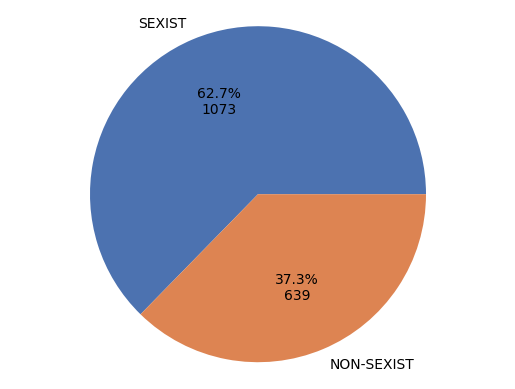

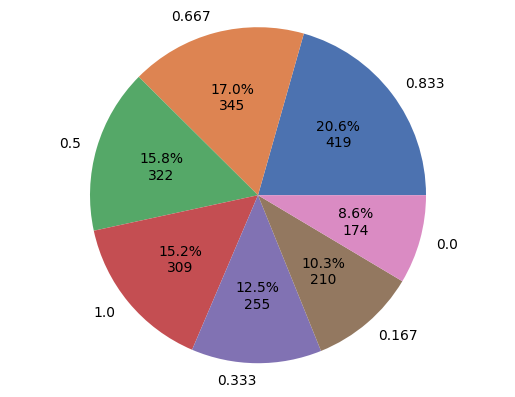

krippendorff's alpha is: 0.27299948476457336


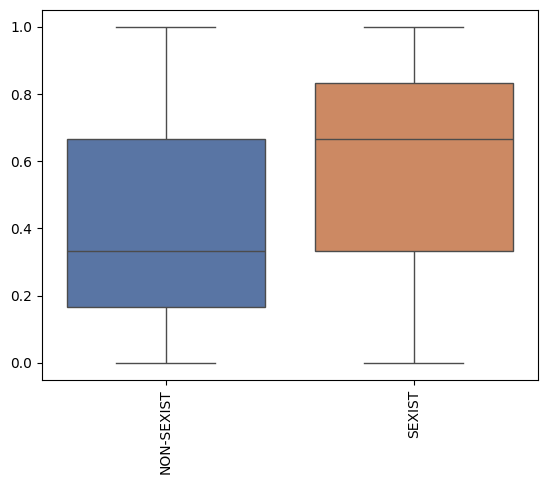

In [24]:
plot_pie_chart_from_dataframe(es_gold_hard_labels_t4_df, "value")
plot_pie_chart_from_dataframe(es_gold_soft_labels_t4_df, "SEXIST")
print("krippendorff's alpha is:", kr_alpha)
plot_box_plot_of_probabilities(es_gold_soft_labels_t4_df[["NON-SEXIST", "SEXIST"]])

### English

In [25]:
en_df = filter_dataframe_by_lang(df, "en")
en_gold_hard_labels_t4_df = gold_hard_labels_t4_df[gold_hard_labels_t4_df["id"].isin(en_df["id_EXIST"])]
en_gold_soft_labels_t4_df = gold_soft_labels_t4_df[gold_soft_labels_t4_df["id"].isin(en_df["id_EXIST"])]
en_gold_hard_labels_t4_df["value"] = en_gold_hard_labels_t4_df["value"].apply(lambda x: "SEXIST" if x == "YES" else "NON-SEXIST")

/tmp/ipykernel_765734/501497835.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_gold_hard_labels_t4_df["value"] = en_gold_hard_labels_t4_df["value"].apply(lambda x: "SEXIST" if x == "YES" else "NON-SEXIST")


In [28]:
label = "labels_task4"
str_to_int = {
    "NO":0,
    "YES":1
}
kr_alpha = get_krippendorf_alpha_agreement(get_annotations_for_a_given_task(en_df, "labels_task4", unique_annotators, lambda x: str_to_int[x]))

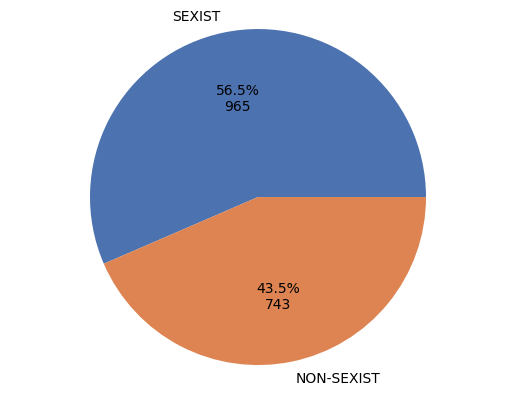

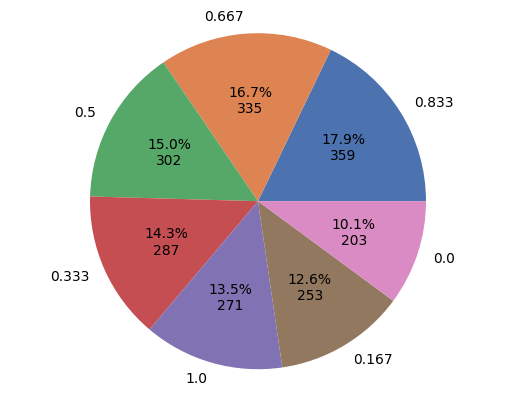

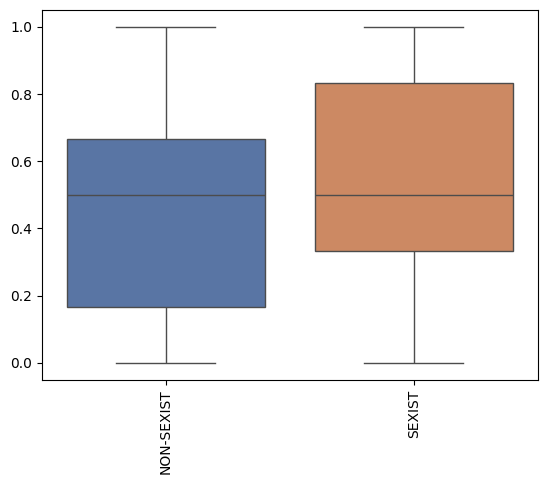

krippendorff's alpha is: 0.2824439397941809


In [29]:
plot_pie_chart_from_dataframe(en_gold_hard_labels_t4_df, "value")
plot_pie_chart_from_dataframe(en_gold_soft_labels_t4_df, "SEXIST")
plot_box_plot_of_probabilities(en_gold_soft_labels_t4_df[["NON-SEXIST", "SEXIST"]])
print("krippendorff's alpha is:", kr_alpha)

### All data

In [96]:
label = "labels_task4"
str_to_int = {
    "NO":0,
    "YES":1
}
kr_alpha = get_krippendorf_alpha_agreement(get_annotations_for_a_given_task(df, "labels_task4", unique_annotators, lambda x: str_to_int[x]))

kr_alpha

0.2786694835293845

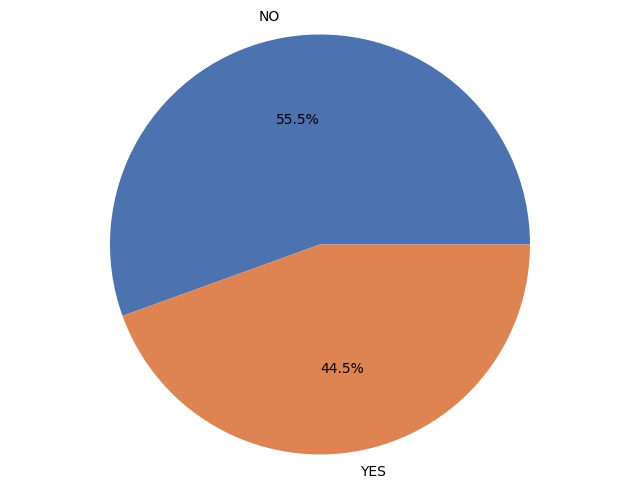

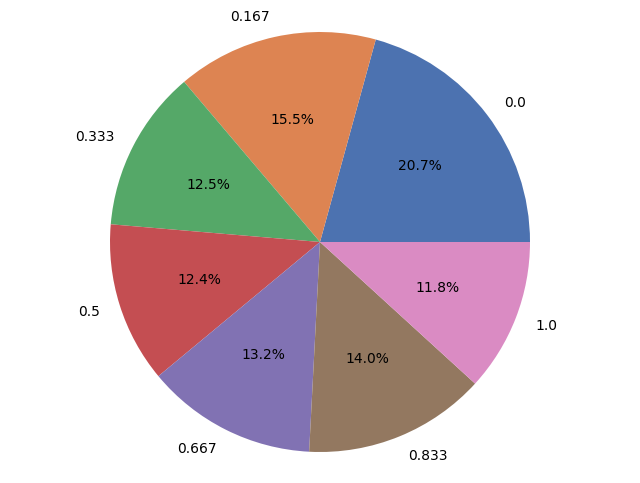

In [24]:
plot_pie_chart_from_dataframe(gold_hard_labels_t4_df, "value", title="")
plot_pie_chart_from_dataframe(gold_soft_labels_t4_df, "YES", title="")
#print("krippendorff's alpha is:", kr_alpha)

## Task 5

In [31]:
gold_hard_labels_t5_path = os.path.join(DATA_BASE_PATH, "evaluation/golds/EXIST2024_training_task5_gold_hard.json")
gold_hard_labels_t5_df = pd.read_json(gold_hard_labels_t5_path)
gold_hard_labels_t5_df.head(2)

,test_case,id,value
0,EXIST2024,110001,DIRECT
1,EXIST2024,110002,DIRECT


In [32]:
gold_soft_labels_t5_path = os.path.join(DATA_BASE_PATH, "evaluation/golds/EXIST2024_training_task5_gold_soft.json")
gold_soft_labels_t5_df = pd.read_json(gold_soft_labels_t5_path)
gold_soft_labels_t5_df["NO"] = gold_soft_labels_t5_df["value"].apply(lambda x: round(x["NO"], 3))
gold_soft_labels_t5_df["DIRECT"] = gold_soft_labels_t5_df["value"].apply(lambda x: round(x["DIRECT"], 3))
gold_soft_labels_t5_df["JUDGEMENTAL"] = gold_soft_labels_t5_df["value"].apply(lambda x: round(x["JUDGEMENTAL"], 3))

gold_soft_labels_t5_df.head(2)

,test_case,id,value,NO,DIRECT,JUDGEMENTAL
0,EXIST2024,110001,"{'DIRECT': 1.0, 'NO': 0.0, 'JUDGEMENTAL': 0.0}",0.0,1.000,0.000
1,EXIST2024,110002,"{'DIRECT': 0.833333333333333, 'JUDGEMENTAL': 0...",0.0,0.833,0.167


### Spanish

In [33]:
es_df = filter_dataframe_by_lang(df, "es")
es_gold_hard_labels_t5_df = gold_hard_labels_t5_df[gold_hard_labels_t5_df["id"].isin(es_df["id_EXIST"])]
es_gold_soft_labels_t5_df = gold_soft_labels_t5_df[gold_soft_labels_t5_df["id"].isin(es_df["id_EXIST"])]

In [34]:
label = "labels_task5"
str_to_int = {
    "DIRECT":0,
    "JUDGEMENTAL":1
}
kr_alpha = get_krippendorf_alpha_agreement(get_annotations_for_a_given_task(es_df, label, unique_annotators, lambda x: str_to_int.get(x, np.nan)))

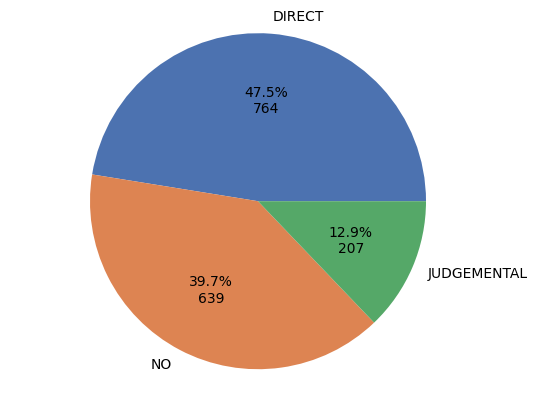

/tmp/ipykernel_765734/3752557398.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  es_gold_hard_labels_t5_without_no = es_gold_hard_labels_t5_df[gold_hard_labels_t5_df["value"] != "NO"]


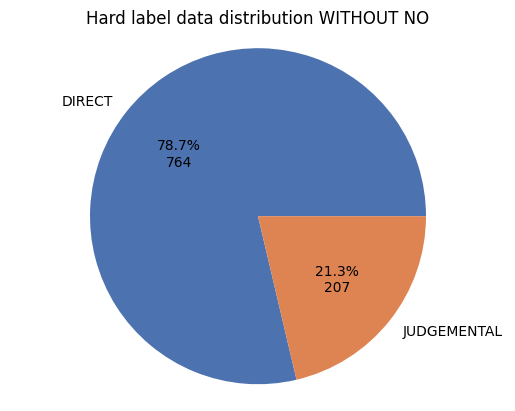

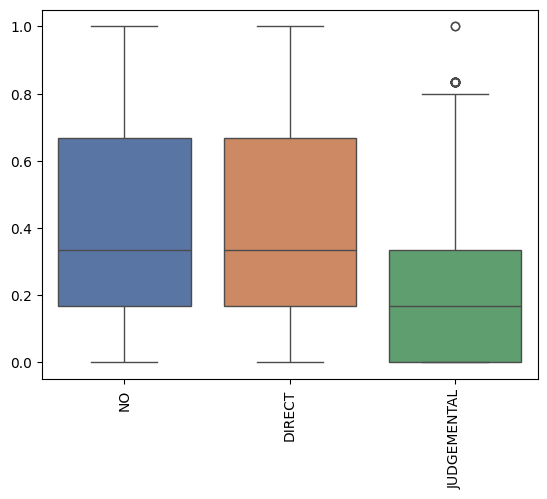

Krippendorf's alpha is: 0.1257435309290803


In [35]:
plot_pie_chart_from_dataframe(es_gold_hard_labels_t5_df, "value")
es_gold_hard_labels_t5_without_no = es_gold_hard_labels_t5_df[gold_hard_labels_t5_df["value"] != "NO"]
plot_pie_chart_from_dataframe(es_gold_hard_labels_t5_without_no, "value", title="Hard label data distribution WITHOUT NO")
plot_box_plot_of_probabilities(es_gold_soft_labels_t5_df[["NO", "DIRECT", "JUDGEMENTAL"]])
print("Krippendorf's alpha is:", kr_alpha)

### English

In [36]:
import os
import pandas as pd
import numpy as np
from scipy import stats

# Función para calcular la media y el intervalo de confianza
def calculate_statistics(values):
    if len(values) > 0:
        mean = np.mean(values)
        std = np.std(values, ddof=1)
        n = len(values)
        conf_interval = stats.t.interval(0.95, n - 1, loc=mean, scale=std / np.sqrt(n))
        conf_interval_str = f"{mean:.4f} ± {conf_interval[1] - mean:.4f}"
    else:
        conf_interval_str = np.nan
    return conf_interval_str

# Función para obtener la parte del medio del nombre del archivo
def extract_run_name(filename):
    base_name = os.path.splitext(filename)[0]  # Eliminar extensión
    parts = base_name.split('_')
    if len(parts) >= 3:
        return parts[1]  # Obtener el segundo elemento (parte del medio)
    else:
        return "Unknown"  # Valor por defecto si no hay suficientes partes

# Función para procesar un archivo CSV de resultados hard
def process_hard_csv(file_path):
    print(f"Processing hard file: {file_path}")
    
    data = pd.read_csv(file_path)
    
    # Filtrar solo las filas donde 'evaluation' comienza con 'EVALUATION'
    data = data[data['evaluation'].str.startswith('EVALUATION')]
    metrics = data['metric'].unique()
    
    results = {}
    run_name = extract_run_name(os.path.basename(file_path))

    # Inicializar un diccionario para la fila actual
    results['Run_Name'] = run_name
    
    classes_name = data.columns[~data.columns.isin(['metric', 'evaluation'])]
    for metric in metrics:
        metric_data = data[data['metric'] == metric]

        for c in classes_name:
            values = metric_data[c].dropna().astype(float).values
            conf_interval_str = calculate_statistics(values)
            results[f'{metric}_{c}'] = conf_interval_str
    
    return results

# Función para procesar un archivo CSV de resultados soft
def process_soft_csv(file_path):
    print(f"Processing soft file: {file_path}")
    
    data = pd.read_csv(file_path)
    
    # Filtrar métricas específicas (ICMSoft, ICMSoftNorm, y CE)
    metrics = data['metric'].unique()
    
    results = {}
    run_name = extract_run_name(os.path.basename(file_path))

    # Inicializar un diccionario para la fila actual
    results['Run_Name'] = run_name
    
    for metric in metrics:
        metric_data = data[data['metric'] == metric]
        
        # Obtener valores de 'average'
        average_values = metric_data['average'].dropna().astype(float).values
        
        # Calcular media y intervalo de confianza para la métrica
        conf_interval_str = calculate_statistics(average_values)
        results[f'{metric}_Average'] = conf_interval_str
    
    return results

# Función principal para recorrer directorios y procesar archivos
def process_directories(root_directory):
    hard_results = {}
    soft_results = {}
    
    for subdir, _, files in os.walk(root_directory):
        for filename in files:
            if filename.startswith('result') and filename.endswith('hard.csv'):
                file_path = os.path.join(subdir, filename)
                run_name = extract_run_name(filename)
                hard_results[run_name] = process_hard_csv(file_path)
            
            elif filename.startswith('result') and filename.endswith('soft.csv'):
                file_path = os.path.join(subdir, filename)
                run_name = extract_run_name(filename)
                soft_results[run_name] = process_soft_csv(file_path)
    
    # Combinar resultados hard y soft en un solo DataFrame
    combined_results = []
    
    # Unir resultados hard y soft por 'Run_Name'
    for run_name in set(hard_results.keys()).union(soft_results.keys()):
        combined_result = {'Run_Name': run_name}
        if run_name in hard_results:
            combined_result.update(hard_results[run_name])
        if run_name in soft_results:
            combined_result.update(soft_results[run_name])
        
        combined_results.append(combined_result)
    
    # Convertir todos los resultados a un DataFrame
    results_df = pd.DataFrame(combined_results)
    
    # Ordenar el DataFrame por la columna 'Run_Name'
    results_df = results_df.sort_values(by='Run_Name')
    
    return results_df

# Directorio raíz a procesar
root_directory = '/home/elural/EXIST-TFM/logs/T6/hard'  # Reemplaza con la ruta a tu directorio raíz

# Ejecutar el procesamiento y obtener el DataFrame final
results_df = process_directories(root_directory)
results_df.sort_values(by='Run_Name', inplace=True)
results_df.to_csv('resultados_t6_hard.csv')

Processing hard file: /home/elural/EXIST-TFM/logs/T6/hard/Image/results_Image_hard.csv
Processing soft file: /home/elural/EXIST-TFM/logs/T6/hard/Image/results_Image_soft.csv
Processing hard file: /home/elural/EXIST-TFM/logs/T6/hard/ContextTextENTweets/results_ContextTextENTweets_hard.csv
Processing soft file: /home/elural/EXIST-TFM/logs/T6/hard/ContextTextENTweets/results_ContextTextENTweets_soft.csv
Processing soft file: /home/elural/EXIST-TFM/logs/T6/hard/ContextTextES/results_ContextTextES_soft.csv
Processing hard file: /home/elural/EXIST-TFM/logs/T6/hard/ContextTextES/results_ContextTextES_hard.csv
Processing hard file: /home/elural/EXIST-TFM/logs/T6/hard/ContextTextESTweets/results_ContextTextESTweets_hard.csv
Processing soft file: /home/elural/EXIST-TFM/logs/T6/hard/ContextTextESTweets/results_ContextTextESTweets_soft.csv
Processing hard file: /home/elural/EXIST-TFM/logs/T6/hard/EarlyES/results_EarlyES_hard.csv
Processing soft file: /home/elural/EXIST-TFM/logs/T6/hard/EarlyES/res

/home/elural/.conda/envs/exist-tfm/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/elural/.conda/envs/exist-tfm/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/elural/.conda/envs/exist-tfm/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/elural/.conda/envs/exist-tfm/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/elural/.conda/envs/exist-tfm/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/elural/.conda/envs/exist

In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats

# Función para calcular la media y el intervalo de confianza
def calculate_statistics(values):
    if len(values) > 0:
        mean = np.mean(values)
        std = np.std(values, ddof=1)
        n = len(values)
        conf_interval = stats.t.interval(0.95, n - 1, loc=mean, scale=std / np.sqrt(n))
        conf_interval_str = f"{mean:.4f} ± {conf_interval[1] - mean:.4f}"
    else:
        conf_interval_str = np.nan
    return conf_interval_str

# Función para obtener la parte del medio del nombre del archivo
def extract_middle_part(filename):
    base_name = os.path.splitext(filename)[0]  # Eliminar extensión
    parts = base_name.split('_')
    if len(parts) >= 3:
        return parts[1]  # Obtener el segundo elemento (parte del medio)
    else:
        return "Unknown"  # Valor por defecto si no hay suficientes partes

# Función para procesar un archivo CSV
def process_csv(file_path):
    print(f"Processing file: {file_path}")
    
    data = pd.read_csv(file_path)
    
    # Filtrar solo las filas donde 'evaluation' comienza con 'EVALUATION'
    filtered_data = data[data['evaluation'].str.startswith('EVALUATION')]
    
    metrics = filtered_data['metric'].unique()
    results = []
    
    # Obtener la parte del medio del nombre del archivo
    run_name = extract_middle_part(os.path.basename(file_path))

    for metric in metrics:
        metric_data = filtered_data[filtered_data['metric'] == metric]

        # Obtener valores de 'YES', 'NO', y 'average'
        yes_values = metric_data['YES'].dropna().astype(float).values
        no_values = metric_data['NO'].dropna().astype(float).values
        average_values = metric_data['average'].dropna().astype(float).values
        
        # Calcular media y intervalo de confianza
        conf_interval_yes_str = calculate_statistics(yes_values)
        conf_interval_no_str = calculate_statistics(no_values)
        conf_interval_avg_str = calculate_statistics(average_values)
        
        # Crear un diccionario para la fila actual
        row = {
            'Run_Name': run_name,
            'Metric': metric,
            'Mean_YES': conf_interval_yes_str,
            'Mean_NO': conf_interval_no_str,
            'Mean_Average': conf_interval_avg_str
        }
        
        results.append(row)
    
    return results

# Función principal para recorrer directorios y procesar archivos
def process_directories(root_directory):
    all_results = []
    
    for subdir, _, files in os.walk(root_directory):
        for filename in files:
            if filename.startswith('result') and filename.endswith('hard.csv'):
                file_path = os.path.join(subdir, filename)
                file_results = process_csv(file_path)
                all_results.extend(file_results)
    
    # Convertir todos los resultados a un DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Ordenar el DataFrame por la columna 'Run_Name'
    results_df = results_df.sort_values(by='Run_Name')
    
    return results_df

# Directorio raíz a procesar
root_directory = '/home/elural/EXIST-TFM/logs/T4/hard'  # Reemplaza con la ruta a tu directorio raíz

# Ejecutar el procesamiento y obtener el DataFrame final
results_df = process_directories(root_directory)
#results_df.to_csv('logs/stereotype_hard_results.csv', index=False)  # Guardar los resultados en un archivo CSV
results_df.to_csv

Processing file: /home/elural/EXIST-TFM/logs/T4/hard/ContextTextENTweets/results_ContextTextENTweets_hard.csv
Processing file: /home/elural/EXIST-TFM/logs/T4/hard/CleanTextEN/results_CleanTextEN_hard.csv
Processing file: /home/elural/EXIST-TFM/logs/T4/hard/ContextTextES/results_ContextTextES_hard.csv
Processing file: /home/elural/EXIST-TFM/logs/T4/hard/CleanContextTextEN/results_CleanContextTextEN_hard.csv
Processing file: /home/elural/EXIST-TFM/logs/T4/hard/ImageBaseline/results_ImageBaseline_hard.csv
Processing file: /home/elural/EXIST-TFM/logs/T4/hard/BaselineTextEN/results_BaselineTextEN_hard.csv
Processing file: /home/elural/EXIST-TFM/logs/T4/hard/ContextTextESTweets/results_ContextTextESTweets_hard.csv
Processing file: /home/elural/EXIST-TFM/logs/T4/hard/CleanTextES/results_CleanTextES_hard.csv
Processing file: /home/elural/EXIST-TFM/logs/T4/hard/CleanContextTextES/results_CleanContextTextES_hard.csv
Processing file: /home/elural/EXIST-TFM/logs/T4/hard/BaselineTextES/results_Base

<bound method NDFrame.to_csv of           Run_Name    Metric         Mean_YES          Mean_NO  \
26  BaselineTextEN  ICM-Norm              NaN              NaN   
27  BaselineTextEN        F1  0.7430 ± 0.0468  0.6660 ± 0.0643   
29  BaselineTextEN        Re  0.7440 ± 0.1146  0.6703 ± 0.1381   
25  BaselineTextEN       ICM              NaN              NaN   
28  BaselineTextEN        Pr  0.7502 ± 0.0485  0.6765 ± 0.0623   
..             ...       ...              ...              ...   
73        TextESWM        Pr  0.7335 ± 0.0771  0.5160 ± 0.1070   
70        TextESWM       ICM              NaN              NaN   
71        TextESWM  ICM-Norm              NaN              NaN   
72        TextESWM        F1  0.7326 ± 0.0303  0.4804 ± 0.2943   
74        TextESWM        Re  0.7510 ± 0.1617  0.5079 ± 0.3402   

        Mean_Average  
26   0.5574 ± 0.0527  
27   0.7045 ± 0.0390  
29   0.7072 ± 0.0365  
25   0.1133 ± 0.1040  
28   0.7133 ± 0.0272  
..               ...  
73   0.6248 ± 

In [37]:
en_df = filter_dataframe_by_lang(df, "en")
en_gold_hard_labels_t5_df = gold_hard_labels_t5_df[gold_hard_labels_t5_df["id"].isin(en_df["id_EXIST"])]
en_gold_soft_labels_t5_df = gold_soft_labels_t5_df[gold_soft_labels_t5_df["id"].isin(en_df["id_EXIST"])]

In [38]:
label = "labels_task5"
str_to_int = {
    "DIRECT":0,
    "JUDGEMENTAL":1,
}

unique_annotators = sorted({annotator for annotators in en_df['annotators'] for annotator in annotators})
kr_alpha = get_krippendorf_alpha_agreement(get_annotations_for_a_given_task(en_df, label, unique_annotators, lambda x: str_to_int.get(x, np.nan)))

In [118]:
# Aplanar la columna 'annotators' y 'labels_task4' en series
annotators_flat = es_df['annotators'].explode()
labels_flat = es_df['labels_task4'].explode()

# Crear un DataFrame con los anotadores y sus respectivas anotaciones
annotators_labels = pd.DataFrame({
    'annotator': annotators_flat,
    'label': labels_flat
})

# Contar el número de anotaciones por anotador
annotations_per_annotator = annotators_labels.groupby('annotator').size()

# Calcular el número promedio de anotaciones por anotador
average_annotations = annotations_per_annotator.mean()
average_annotations


26.763157894736842

In [8]:
import pandas as pd
from collections import Counter
en_df = filter_dataframe_by_lang(df, "en")
def calcular_promedio_anotaciones(df):
    # Inicializar un contador para las anotaciones por anotador
    anotaciones_por_anotador = Counter()
    
    # Iterar sobre cada fila del DataFrame
    for _, row in df.iterrows():
        # Obtener la lista de anotadores y sus anotaciones para task4
        anotadores = row['annotators']
        anotaciones_task4 = row['labels_task4']
        
        # Asegurarse de que las listas tengan la misma longitud
        if len(anotadores) != len(anotaciones_task4):
            print(f"Error: Longitudes no coinciden para la fila {row.name}")
            continue
        
        # Incrementar el contador para cada anotador
        for anotador in anotadores:
            anotaciones_por_anotador[anotador] += 1
    
    # Calcular el número total de anotaciones y anotadores únicos
    total_anotaciones = sum(anotaciones_por_anotador.values())
    total_anotadores = len(anotaciones_por_anotador)
    
    # Calcular el promedio
    promedio_anotaciones = total_anotaciones / total_anotadores if total_anotadores > 0 else 0
    
    return promedio_anotaciones, total_anotaciones, total_anotadores

# Asumiendo que el DataFrame se llama 'df'
promedio, total_anotaciones, total_anotadores = calcular_promedio_anotaciones(en_df)
promedio, total_anotaciones

(26.8, 12060)

In [34]:
import pandas as pd
import numpy as np
from collections import Counter
es_df = filter_dataframe_by_lang(df, "es")
en_df = filter_dataframe_by_lang(df, "en")
def calcular_estadisticas_anotaciones(df):
    # Inicializar contadores para las anotaciones por anotador
    anotaciones_por_anotador_task4 = Counter()
    anotaciones_por_anotador_task5 = Counter()
    
    # Iterar sobre cada fila del DataFrame
    for _, row in df.iterrows():
        anotadores = row['annotators']
        anotaciones_task4 = row['labels_task4']
        anotaciones_task5 = row['labels_task5']
        
        # Asegurarse de que las listas tengan la misma longitud
        if len(anotadores) != len(anotaciones_task4) or len(anotadores) != len(anotaciones_task5):
            print(f"Error: Longitudes no coinciden para la fila {row.name}")
            continue

        # Incrementar los contadores para cada anotador
        for anotador, anotacion_task4, anotacion_task5 in zip(anotadores, anotaciones_task4, anotaciones_task5):
            anotaciones_por_anotador_task4[anotador] += 1

            # Para task5, solo contar si no es '-' o 'UNKNOWN'
            if anotacion_task5 not in ['-', 'UNKNOWN']:

                anotaciones_por_anotador_task5[anotador] += 1
    
    # Calcular estadísticas
    total_anotadores = len(set(anotaciones_por_anotador_task4.keys()) | set(anotaciones_por_anotador_task5.keys()))
    
    total_anotaciones_task4 = sum(anotaciones_por_anotador_task4.values())
    promedio_anotaciones_task4 = total_anotaciones_task4 / total_anotadores if total_anotadores > 0 else 0
    
    total_anotaciones_task5 = sum(anotaciones_por_anotador_task5.values())
    promedio_anotaciones_task5 = total_anotaciones_task5 / total_anotadores if total_anotadores > 0 else 0
    
    return {
        'total_anotadores': total_anotadores,
        'promedio_anotaciones_task4': promedio_anotaciones_task4,
        'promedio_anotaciones_task5': promedio_anotaciones_task5
    }

# Asumiendo que el DataFrame se llama 'df'
resultados = calcular_estadisticas_anotaciones(es_df)

print(f"Número total de anotadores únicos: {resultados['total_anotadores']}")
print(f"Promedio de anotaciones por anotador en la tarea 4: {resultados['promedio_anotaciones_task4']:.2f}")
print(f"Promedio de anotaciones por anotador en la tarea 5: {resultados['promedio_anotaciones_task5']:.2f}")

Número total de anotadores únicos: 456
Promedio de anotaciones por anotador en la tarea 4: 26.76
Promedio de anotaciones por anotador en la tarea 5: 15.27


In [35]:
en_df['labels_task5'].explode().value_counts()

labels_task5
-              5566
DIRECT         3903
JUDGEMENTAL    2515
UNKNOWN          76
Name: count, dtype: int64

In [13]:
en_df['labels_task6'] = en_df['labels_task6'].apply(lambda x: [np.nan if val in [['-'], ['UNKNOWN']] else val for val in x])

# Aplanar la columna 'annotators' y 'labels_task5' en series
annotators_flat = en_df['annotators'].explode()
labels_task5_flat = en_df['labels_task6'].explode()

# Crear un DataFrame con anotadores y sus respectivas etiquetas
annotators_labels = pd.DataFrame({
    'annotator': annotators_flat,
    'label': labels_task5_flat
})

# Filtrar las anotaciones válidas (excluyendo NaN)
valid_annotations = annotators_labels.dropna()

# Contar el número de anotaciones válidas por anotador
annotations_per_annotator = valid_annotations.groupby('annotator').size()

# Calcular el número promedio de anotaciones por anotador
average_annotations_per_annotator = annotations_per_annotator.mean()

/tmp/ipykernel_84785/1342520919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_df['labels_task6'] = en_df['labels_task6'].apply(lambda x: [np.nan if val in [['-'], ['UNKNOWN']] else val for val in x])


In [14]:
average_annotations_per_annotator

14.441964285714286

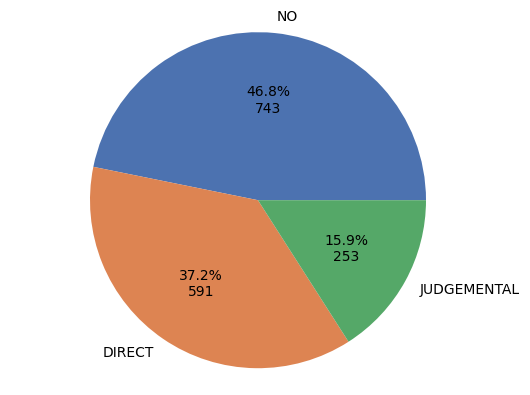

/tmp/ipykernel_765734/3127859630.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  en_gold_hard_labels_t5_without_no = en_gold_hard_labels_t5_df[gold_hard_labels_t5_df["value"] != "NO"]


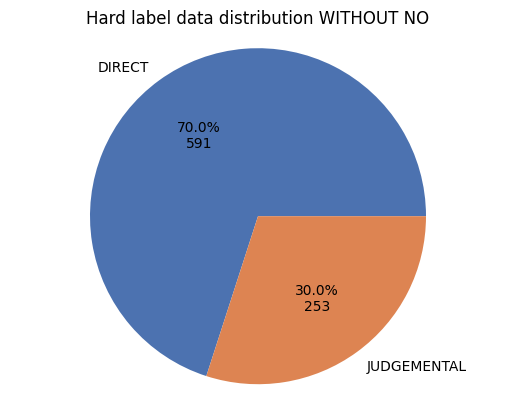

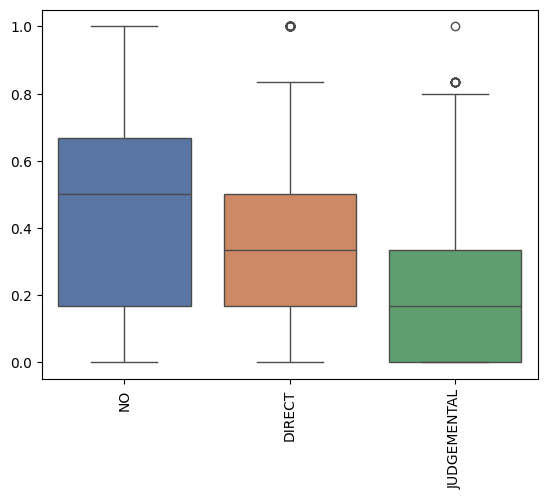

Krippendorf's alpha is: 0.05559148356977994


In [40]:
plot_pie_chart_from_dataframe(en_gold_hard_labels_t5_df, "value",)
en_gold_hard_labels_t5_without_no = en_gold_hard_labels_t5_df[gold_hard_labels_t5_df["value"] != "NO"]
plot_pie_chart_from_dataframe(en_gold_hard_labels_t5_without_no, "value", title="Hard label data distribution WITHOUT NO")
plot_box_plot_of_probabilities(en_gold_soft_labels_t5_df[["NO", "DIRECT", "JUDGEMENTAL"]])
print("Krippendorf's alpha is:", kr_alpha)

### All data

In [57]:
label = "labels_task5"
str_to_int = {
    "DIRECT":0,
    "JUDGEMENTAL":1,
    "NO": 2,
}
kr_alpha = get_krippendorf_alpha_agreement(get_annotations_for_a_given_task(df, label, unique_annotators, lambda x: str_to_int.get(x, np.nan)))

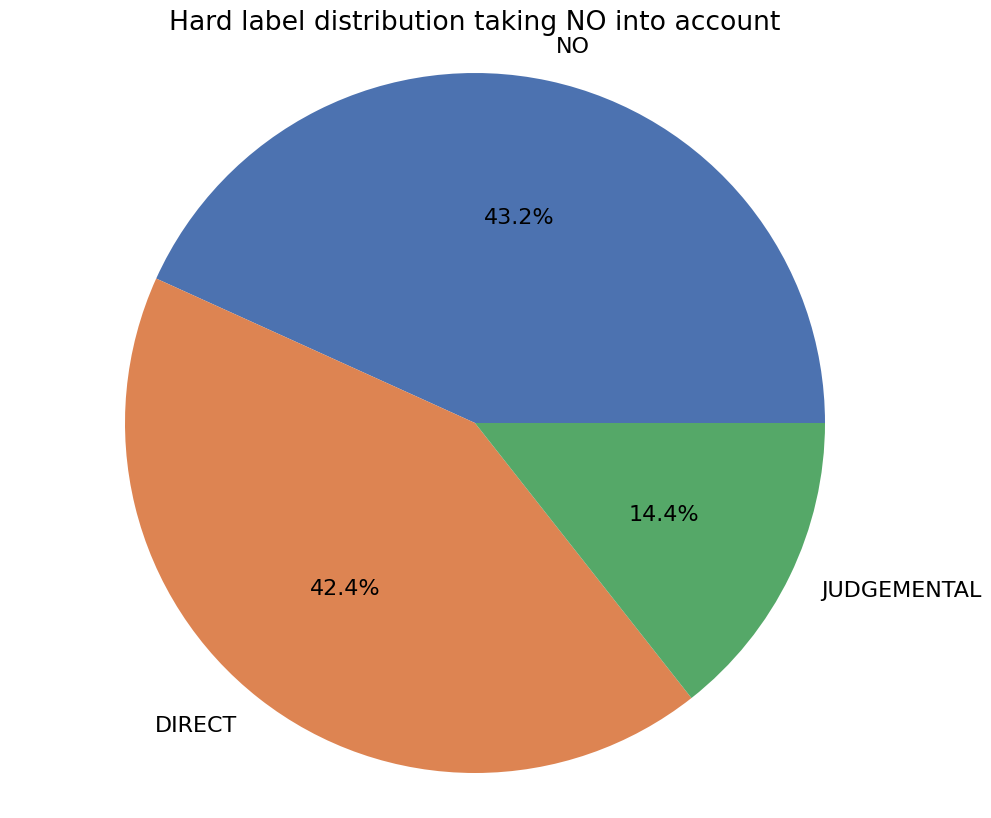

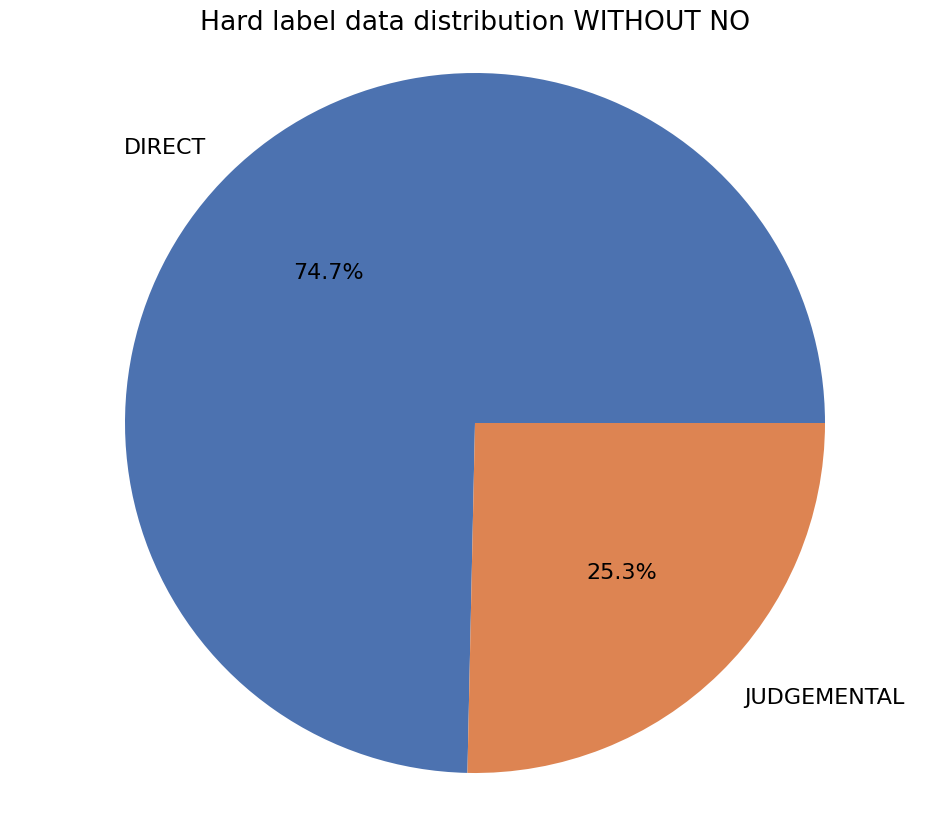

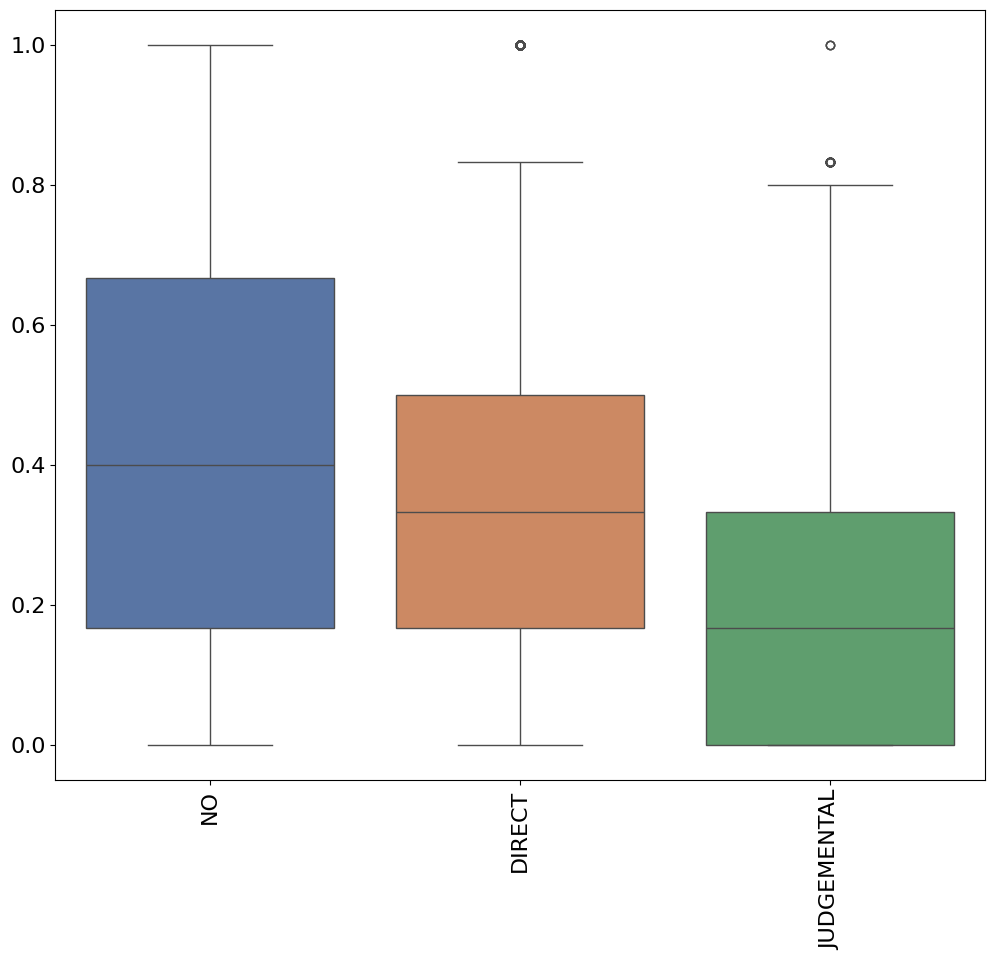

/tmp/ipykernel_2313832/3772973656.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=x_col, y=y_col, data=df, palette='deep')


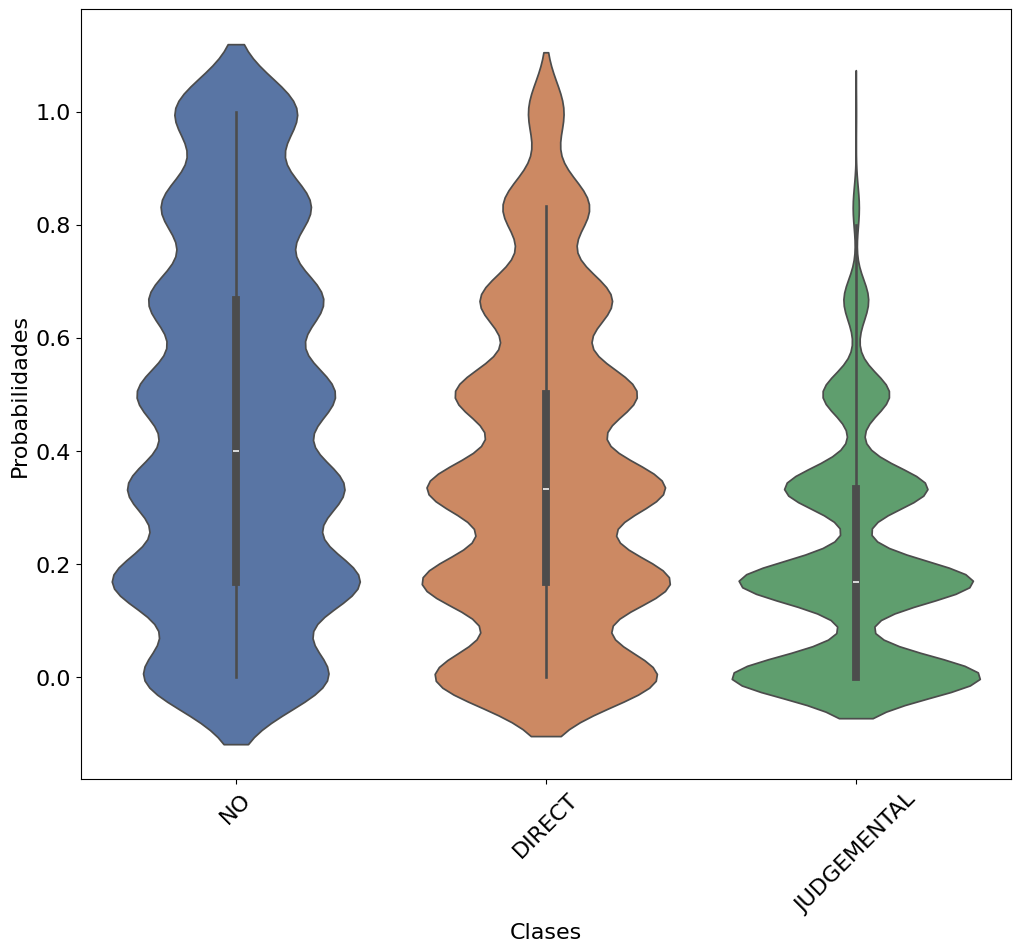

Krippendorf's alpha is: 0.09502284883671874


In [58]:
plot_pie_chart_from_dataframe(gold_hard_labels_t5_df, "value", title="Hard label distribution taking NO into account")
gold_hard_labels_t5_without_no = gold_hard_labels_t5_df[gold_hard_labels_t5_df["value"] != "NO"]
plot_pie_chart_from_dataframe(gold_hard_labels_t5_without_no, "value", title="Hard label data distribution WITHOUT NO")
plot_box_plot_of_probabilities(gold_soft_labels_t5_df[["NO", "DIRECT", "JUDGEMENTAL"]])
plot_violin_plot(gold_soft_labels_t5_df[["NO", "DIRECT", "JUDGEMENTAL"]], "Clases", "Probabilidades")
print("Krippendorf's alpha is:", kr_alpha)

## Task 6

In [41]:
gold_hard_labels_t6_path = os.path.join(DATA_BASE_PATH, "evaluation/golds/EXIST2024_training_task6_gold_hard.json")
gold_hard_labels_t6_df = pd.read_json(gold_hard_labels_t6_path)
gold_hard_labels_t6_df = expand_labels(gold_hard_labels_t6_df, "value")
gold_hard_labels_t6_df.head(2)

,test_case,id,value,IDEOLOGICAL-INEQUALITY,MISOGYNY-NON-SEXUAL-VIOLENCE,NO,OBJECTIFICATION,SEXUAL-VIOLENCE,STEREOTYPING-DOMINANCE
0,EXIST2024,110001,[IDEOLOGICAL-INEQUALITY],1,0,0,0,0,0
1,EXIST2024,110002,"[IDEOLOGICAL-INEQUALITY, MISOGYNY-NON-SEXUAL-V...",1,1,0,0,0,0


In [42]:
gold_soft_labels_t6_path = os.path.join(DATA_BASE_PATH, "evaluation/golds/EXIST2024_training_task6_gold_soft.json")
gold_soft_labels_t6_df = pd.read_json(gold_soft_labels_t6_path)
gold_soft_labels_t6_df = expand_labels_with_values(gold_soft_labels_t6_df, "value")
gold_soft_labels_t6_df.head(2)

,test_case,id,value,IDEOLOGICAL-INEQUALITY,MISOGYNY-NON-SEXUAL-VIOLENCE,NO,OBJECTIFICATION,SEXUAL-VIOLENCE,STEREOTYPING-DOMINANCE
0,EXIST2024,110001,"{'IDEOLOGICAL-INEQUALITY': 1.0, 'STEREOTYPING-...",1.000000,0.166667,0.0,0.0,0.0,0.166667
1,EXIST2024,110002,"{'IDEOLOGICAL-INEQUALITY': 0.6666666666666661,...",0.666667,0.666667,0.0,0.0,0.0,0.166667


### Spanish

In [43]:
es_df = filter_dataframe_by_lang(df, "es")
es_gold_hard_labels_t6_df = gold_hard_labels_t6_df[gold_hard_labels_t6_df["id"].isin(es_df["id_EXIST"])]
es_gold_soft_labels_t6_df = gold_soft_labels_t6_df[gold_soft_labels_t6_df["id"].isin(es_df["id_EXIST"])]

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()


In [23]:
en_df = filter_dataframe_by_lang(df, "en")



def dummy_fn(df):
    n_samples = len(df)
    n_annotators = len(df['annotators'].explode().unique().tolist())
    print(n_annotators)

    unique_list = df['annotators'].explode().unique().tolist()
    annotators_to_idx = dict(zip(unique_list, range(len(unique_list))))

    array_of_annotations = np.full((n_samples, n_annotators, 5), np.nan)

    mlb = MultiLabelBinarizer()

    one_hot_encode = df['labels_task6'].explode().apply(lambda x: set(x) if x not in [['-'], ['UNKNOWN']] else np.nan)

    mlb = mlb.fit(one_hot_encode.dropna().values)

    for i, s in enumerate(df.iterrows()):
        anns = s[1]['annotators']
        for j, ann in enumerate(anns):
            idx = annotators_to_idx[ann]
            if s[1]['labels_task6'][j] in [['UNKNOWN'], ['-']]:
                    aux = np.full((1, 5), np.nan)
                    continue
        
            aux = mlb.transform([s[1]['labels_task6'][j]])
                

            array_of_annotations[i, idx] = aux
    
    return array_of_annotations
        

xd = dummy_fn(en_df)

aux = 0
for c in range(5):
    aux += get_krippendorf_alpha_agreement(xd[:, :, 4].T)
print(aux / 5)

450
0.2076699746087626


In [44]:
label = "labels_task6"
str_to_int =  {
        "NO": 0,
        "IDEOLOGICAL-INEQUALITY": 1,
        "MISOGYNY-NON-SEXUAL-VIOLENCE": 2,
        "OBJECTIFICATION": 3,
        "SEXUAL-VIOLENCE": 4,
        "STEREOTYPING-DOMINANCE": 5,
    }
kr_alpha = get_krippendorf_alpha_agreement(get_annotations_for_a_given_task(en_df, "labels_task6", unique_annotators, lambda x: str_to_int[x]))

TypeError: unhashable type: 'list'

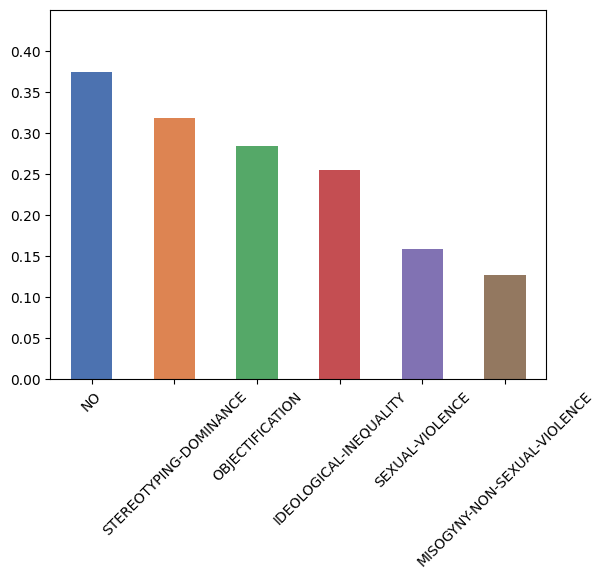

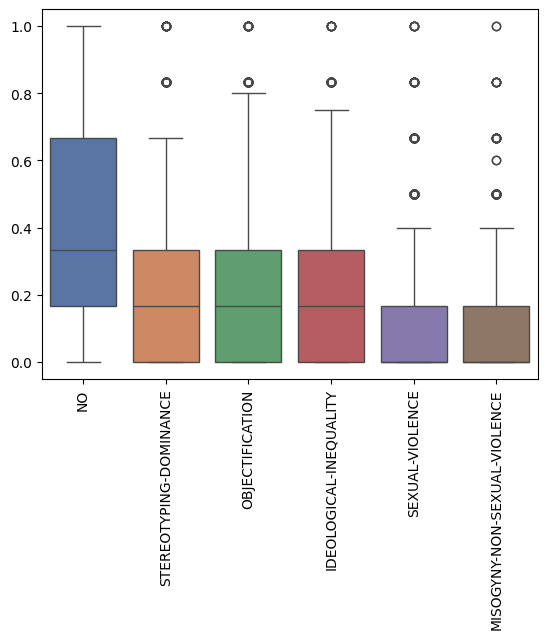

In [47]:
plot_normalized_label_frequencies(es_gold_hard_labels_t6_df, ["NO", "IDEOLOGICAL-INEQUALITY", "MISOGYNY-NON-SEXUAL-VIOLENCE", "OBJECTIFICATION", "SEXUAL-VIOLENCE", "STEREOTYPING-DOMINANCE"])
plot_box_plot_of_probabilities(es_gold_soft_labels_t6_df[["NO", "STEREOTYPING-DOMINANCE", "OBJECTIFICATION", "IDEOLOGICAL-INEQUALITY", "SEXUAL-VIOLENCE", "MISOGYNY-NON-SEXUAL-VIOLENCE"]])
#plot_violin_plot(en_gold_soft_labels_t6_df[["NO", "IDEOLOGICAL-INEQUALITY", "MISOGYNY-NON-SEXUAL-VIOLENCE", "OBJECTIFICATION", "SEXUAL-VIOLENCE", "STEREOTYPING-DOMINANCE"]], "Clases", "Probabilidades")

### English

In [48]:
en_df = filter_dataframe_by_lang(df, "en")
en_gold_hard_labels_t6_df = gold_hard_labels_t6_df[gold_hard_labels_t6_df["id"].isin(en_df["id_EXIST"])]
en_gold_soft_labels_t6_df = gold_soft_labels_t6_df[gold_soft_labels_t6_df["id"].isin(en_df["id_EXIST"])]

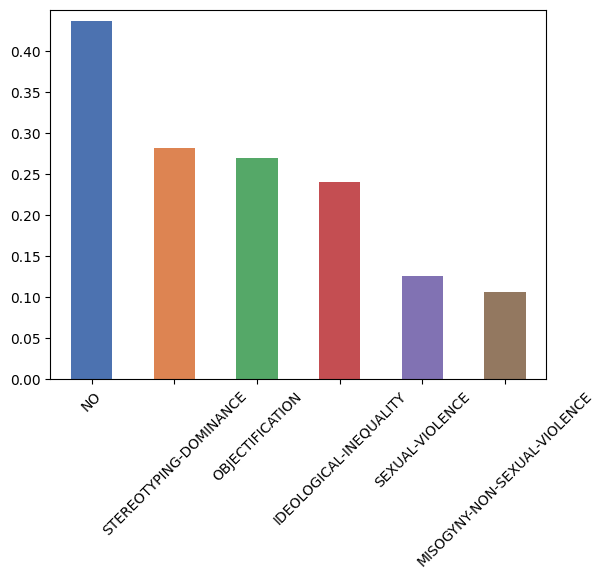

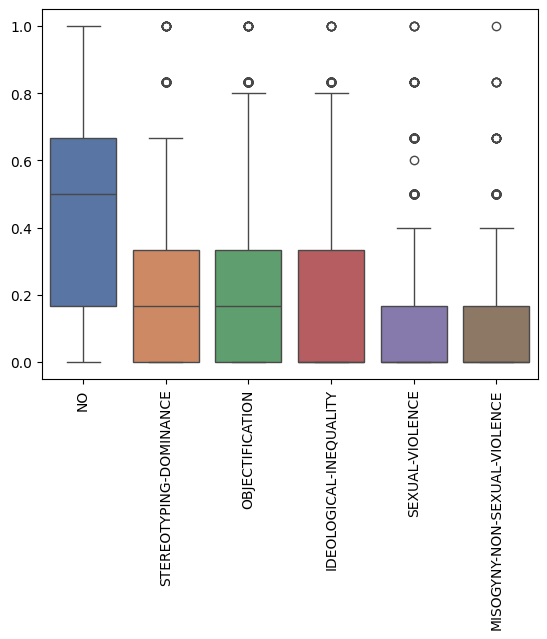

In [49]:
plot_normalized_label_frequencies(en_gold_hard_labels_t6_df, ["NO", "IDEOLOGICAL-INEQUALITY", "MISOGYNY-NON-SEXUAL-VIOLENCE", "OBJECTIFICATION", "SEXUAL-VIOLENCE", "STEREOTYPING-DOMINANCE"])
plot_box_plot_of_probabilities(en_gold_soft_labels_t6_df[["NO", "STEREOTYPING-DOMINANCE", "OBJECTIFICATION", "IDEOLOGICAL-INEQUALITY", "SEXUAL-VIOLENCE", "MISOGYNY-NON-SEXUAL-VIOLENCE"]])

### All data

In [ ]:
plot_normalized_label_frequencies(gold_hard_labels_t6_df, ["NO", "IDEOLOGICAL-INEQUALITY", "MISOGYNY-NON-SEXUAL-VIOLENCE", "OBJECTIFICATION", "SEXUAL-VIOLENCE", "STEREOTYPING-DOMINANCE"])
plot_box_plot_of_probabilities(gold_soft_labels_t6_df[["NO", "IDEOLOGICAL-INEQUALITY", "MISOGYNY-NON-SEXUAL-VIOLENCE", "OBJECTIFICATION", "SEXUAL-VIOLENCE", "STEREOTYPING-DOMINANCE"]])
plot_violin_plot(gold_soft_labels_t6_df[["NO", "IDEOLOGICAL-INEQUALITY", "MISOGYNY-NON-SEXUAL-VIOLENCE", "OBJECTIFICATION", "SEXUAL-VIOLENCE", "STEREOTYPING-DOMINANCE"]], "Clases", "Probabilidades")